We will use Gibbs sampling to perform Bayesian inference on a change-point problem.

Consider a dataset of observed counts indexed over time. We can model count data as a Poisson distribution by determining the mean of the Poisson. If we assume that the mean changed at some point in time, we get a change-point model. We would like to determine when the change likely occurred, and also the before-and-after means.

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.stats as ss

In [91]:
n_obs = 80
n_true = ss.randint(low=30, high=70).rvs()

lambda_true = [3.0, 8.2]

y_obs = np.concatenate([
    ss.poisson(mu=lambda_true[0]).rvs(size=n_true),
    ss.poisson(mu=lambda_true[1]).rvs(size=n_obs-n_true),
])

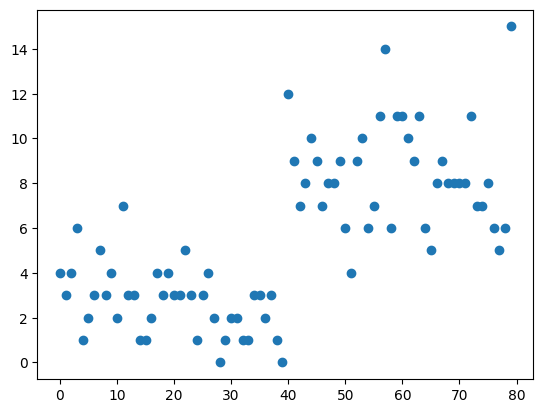

In [92]:
plt.scatter(range(n_obs), y_obs)

- Do prior predictive stuff
- Do posterior predictive stuff

The model is

\begin{align*}
    y_i & \sim \text{Poisson}\left(\lambda_1\right), \; i < n \\
    y_i & \sim \text{Poisson}\left(\lambda_2\right), \; i \geq n \\
\end{align*}

with prior distributions

\begin{align*}
    \lambda_j & \sim \Gamma\left(a,b\right), \; j=1,2 \\
    n & \sim \text{Uniform}\left\{1,2,...,N_{\text{obs}}\right\} \\
\end{align*}

The Bayesian program is to determine the posterior distribution over model parameters given the observed data,

$$ p\left(\lambda_1, \lambda_2, n\,\middle| \, Y\right) $$

where $Y = \left\{y_i\right\}_{i=1}^{N_{\text{obs}}}$.

### Gibbs sampling

Given a fixed set of parameters $\left(\lambda_1, \lambda_2, n\right)$, the data likelihood is:

\begin{align*}
    p\left(Y\,\middle|\,\lambda_1, \lambda_2, n\right) & = \prod_{i=1}^n \text{Poisson}\left(y_i; \lambda_1\right) \cdot \prod_{i=n+1}^{N_{\text{obs}}} \text{Poisson}\left(y_i; \lambda_2\right) \\
\end{align*}

By Bayes' theorem, the posterior distribution is

\begin{align*}
    p\left(\lambda_1, \lambda_2, n \, \middle| \, Y \right) & \propto p\left(Y\,\middle|\,\lambda_1, \lambda_2, n\right) p\left(\lambda_1, \lambda_2, n\right) \\
    & = p\left(Y\,\middle|\,\lambda_1, \lambda_2, n\right) p\left(\lambda_1\right)p\left(\lambda_2\right)p\left(n\right) \\
\end{align*}

Let's calculate the complete conditional for $\lambda_1$.

\begin{align*}
    p\left(\lambda_1 \, \middle| \, \lambda_2, n, Y\right) & = p\left(\lambda_1, \lambda_2, n \,\middle| \,Y \right) / p\left(\lambda_2, n\right)\\
    & \propto p\left(Y\,\middle|\,\lambda_1, \lambda_2, n\right) p\left(\lambda_1\right)p\left(\lambda_2\right)p\left(n\right) / p\left(\lambda_2, n\right) \\
    & = p\left(Y\,\middle|\,\lambda_1, \lambda_2, n\right) p\left(\lambda_1\right) \\
    & \propto \left[\prod_{i=1}^n \text{Poisson}\left(y_i; \lambda_1\right) \right] \Gamma\left(\lambda_1; a,b\right) \\
\end{align*}

where we have retained only the terms involving $\lambda_1$.

\begin{align*}
    p\left(\lambda_1 \, \middle| \, \lambda_2, n, Y\right) & \propto \lambda_1^{a-1} e^{-b\lambda_1} \prod_{i=1}^n \frac{\lambda_1^{y_i}}{y_1!}e^{-\lambda_1} \\
\end{align*}

\begin{align*}
    p\left(\lambda_1 \, \middle| \, \lambda_2, n, Y\right) & \propto \lambda_1^{a-1} e^{-b\lambda_1} \prod_{i=1}^n \lambda_1^{y_i}e^{-\lambda_1} \\
    & \propto e^{-\left(b+n\right)\lambda_1}\lambda_1^{a - 1 + \sum_{i=1}^n y_i} \\
\end{align*}

\begin{align*}
    & \propto \lambda_1^{\bar{a} -1 }e^{-\bar{b}\lambda_1} \\
    & \propto \Gamma\left(\lambda_1; \bar{a}, \bar{b}\right) \\ 
\end{align*}

where $\bar{a} = a + \sum_{i=1}^n y_i$ and $\bar{b} = b + n $.

### Complete conditional for $n$

\begin{align*}
    p\left(n\,\middle|\, \lambda_1, \lambda_2, Y \right) & = p\left(Y\, \middle| \, \lambda_1, \lambda_2, n \right)p\left(\lambda_1, \lambda_2, n \right) \\
    & = p\left(Y\, \middle| \, \lambda_1, \lambda_2, n \right)p\left(\lambda_1\right)p\left(\lambda_2\right)p\left( n \right) \\
    & \propto p\left(Y\, \middle| \, \lambda_1, \lambda_2, n \right)p\left( n \right) \\
    & \propto \prod_{i=1}^n \text{Poisson}\left(y_i; \lambda_1\right) \cdot \prod_{i=n+1}^{N_{\text{obs}}} \text{Poisson}\left(y_i; \lambda_2\right) \\
    & = \prod_{i=1}^n \frac{\lambda_1^{y_i}}{y_i!}e^{-\lambda_1} \cdot \prod_{i=n+1}^{N_{\text{obs}}} \frac{\lambda_2^{y_i}}{y_i!}e^{-\lambda_2} \\
\end{align*}

\begin{align*}
    \log p\left(n\,\middle|\,\lambda_1,\lambda_2, Y\right) + \text{const.} & = \sum_{i=1}^n \log \left( \frac{\lambda_1^{y_i}}{y_i!}e^{-\lambda_1}\right) + \sum_{i=n+1}^{N_{\text{obs}}} \log \left( \frac{\lambda_2^{y_i}}{y_i!}e^{-\lambda_2}\right)\\
\end{align*}

\begin{align*}
    & = \sum_{i=1}^n \left[ y_i \log \lambda_1 - \log y_i! - \lambda_1 \right] + \sum_{i=n+1}^{N_{\text{obs}}} \left[ y_i \log \lambda_2 - \log y_i! - \lambda_2 \right] \\
\end{align*}

\begin{align*}
    & = \log \lambda_1 \sum_{i=1}^n y_i + \log \lambda_2 \sum_{i=n+1}^{N_{\text{obs}}} y_i - n \lambda_1 - \left(N_{\text{obs}} - n\right) \lambda_2 - \sum_{i=1}^{N_{\text{obs}}} \log y_i! \\
\end{align*}

Notice that the $\log y_i!$ term doesn't depend on $n$ and so we can omit from our following calculations.

This doesn't have a nice distributional form, but since it is a discrete distribution over $n \in \left\{0,1,2,...,N_{\text{obs}}\right\}$, we can compute each value and normalize it to get the complete conditional distribution of $n$. Then we can sample from this distribution to get a draw for the Gibbs sampler.

In [93]:
a = 3
b = 2
def lambda_1_comp_cond(lambda_, n, y_obs):
    a_bar = a + y_obs[:n].sum()
    b_bar = b + n
    return ss.gamma(a=a_bar, scale=1/b_bar).rvs()

def lambda_2_comp_cond(lambda_, n, y_obs):
    a_bar = a + y_obs[n:].sum()
    b_bar = b + (len(y_obs) - n)
    return ss.gamma(a=a_bar, scale=1/b_bar).rvs()

In [94]:
def p_n_comp_cond(lambda_, y_obs):
    n_obs = len(y_obs)
    log_p_n = np.zeros(n_obs)
    for n in range(n_obs):
        t1 = y_obs[:n].sum() * np.log(lambda_[0])
        t2 = y_obs[n:].sum() * np.log(lambda_[1])
        t3 = n * lambda_[0]
        t4 = (n_obs - n) * lambda_[1]
        log_p_n[n] = t1 + t2 - t3 - t4

    p_n = np.exp(log_p_n)
    p_n = p_n / p_n.sum()

    return np.random.choice(range(n_obs), p=p_n)

In [95]:
a = 2
b = 1

n_iters = 1_000
trace = np.empty((n_iters, 3))

# initial conditions
lambda_ = ss.gamma(a=a, scale=1/b).rvs(2)
n = ss.randint(low=0, high=n_obs).rvs()

for i in range(n_iters):

    lambda_[0] = lambda_1_comp_cond(lambda_, n, y_obs)
    lambda_[1] = lambda_2_comp_cond(lambda_, n, y_obs)
    n = p_n_comp_cond(lambda_, y_obs)

    trace[i,:] = [lambda_[0], lambda_[1], n]

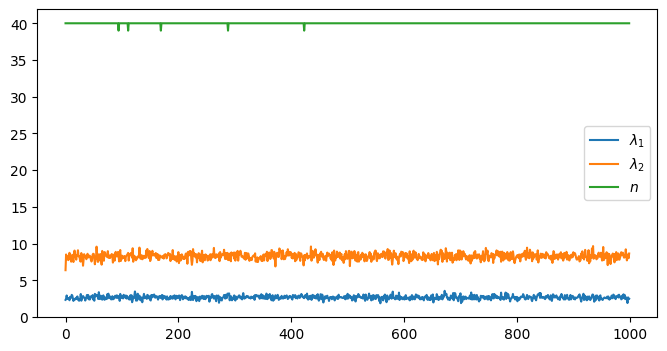

In [96]:
fig, ax = plt.subplots(figsize=(8,4))

ax.plot(trace[:,0], label=r"$\lambda_1$")
ax.plot(trace[:,1], label=r"$\lambda_2$")
ax.plot(trace[:,2], label=r"$n$")
ax.legend()
plt.show()

In [98]:
np.mean(trace[200:], axis=0)

array([ 2.68013548,  8.29153576, 39.9975    ])

In [100]:
lambda_true

[3.0, 8.2]

In [101]:
lambda_

array([2.49492488, 8.65371272])

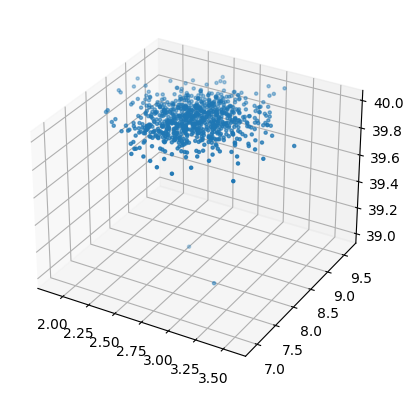

In [104]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.scatter3D(trace[200:,0], trace[200:,1], trace[200:,2], s=5)